<a href="https://colab.research.google.com/github/jieun0441/Stimulus-Payment/blob/main/Lockdown_of_SP_Simulation_ver7_each_week_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### data load & Setting

In [1]:
# For Colab Use
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Package loading
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [3]:
# data load for regression
data = pd.read_stata("/content/drive/MyDrive/SP/Table for Regression_20241103.dta")

In [4]:
# data to calculate X vars
# SWMxinf_S
SWMxinf_S = pd.read_excel('/content/drive/MyDrive/SP/SWMxinf_from_Seoul.xlsx') # 유동인구 from Seoul to Seoul
# SWMxinf_NS
SWMxinf_NS = pd.read_excel('/content/drive/MyDrive/SP/SWMxinf_from_nonSeoul.xlsx') # 유동인구 from 비서울 to Seoul

In [5]:
# Card with Restrictions
Card = pd.read_stata('/content/drive/MyDrive/SP/Simulation_1103/All_OD_Cards_from_week19_to_35_880328.dta')

In [ ]:
Card.columns

Index(['v1', 'week', 'orig_sido', 'dest_sido', 'orig', 'dest', 'OD', 'week_OD',
       'num_total', '_merge_num_total', 'avg1017_8', '_merge_avg1017_8',
       'netCard', 'orig_inf', 'week_area', 'dest_inf', '_merge',
       'netCardxorig_inf', 'netCardxdest_inf', 'week_dest', 'week_orig'],
      dtype='object')

In [6]:
# Card without Restrictions
### netCard_woR of Seoul residents
# 1)
# Card_wo_S = pd.read_stata("/content/drive/MyDrive/SP/Simulation_1115/long dataset_4개이상OD_2020 week10_17 OD distribution_fromS_check_avg1017_8_added_orig도구로구항동제외.dta")
# # 2)
# Card_wo_S = pd.read_stata("/content/drive/MyDrive/SP/Simulation_1115/long dataset_2020 week10_17주전체OD는 살리고 distribution만_4개이상OD_fromS_check_avg1017_8_orig도구로구항동제외.dta")
# # 3)
Card_wo_S = pd.read_stata("/content/drive/MyDrive/SP/Simulation_1115/Lockdown Scenario_서울내각OD별 Lockdown_num_total_week19 to 35.dta")

In [7]:
# Card_wo_S['week_orig']= Card_wo_S['week'].astype(str) + Card_wo_S['orig']
# Card_wo_S['week_dest']= Card_wo_S['week'].astype(str) + Card_wo_S['dest']
Card_wo_S.columns

Index(['orig_sido', 'orig_sgng', 'orig_adong', 'dest_sido', 'dest_sgng',
       'dest_adong', 'week', 'year', 'num_total', 'num_stmchk', 'orig', 'dest',
       'OD', 'orig_gu', 'dest_gu', 'total_sum_in_the_week', 'por_in_the_week',
       'sum_portion', 'week_dest', 'week_orig',
       'Seoul_residents_T_in_the_week', 'Lockdown_num_total', 'avg1017_8',
       '_merge_avg1017_8', 'netCard_woR'],
      dtype='object')

### OLS Regression with prepared data

In [9]:
# # 1)avg
data.rename(columns = {'X_sameOD_netCardxorig_inf_de4':'signetCardxinf_m1wk_same_de4',
                       'X_diffOD_netCardxorig_inf_de4':'signetCardxinf_m1wk_diff_de4',
                       'X_exposure_netCardxdest_inf_de4':'Exposu_netCardxdestinf_wkm1_de4'}, inplace=True)

# Define the list of gu values to filter
gu_values = ["강북구", "관악구", "노원구", "동대문구", "동작구", "양천구", "영등포구", "용산구", "은평구", "종로구", "중랑구"]

# Filter the data to include only rows where 'gu' is in gu_values
filtered_data = data[data['gu'].isin(gu_values)]

# Define the explanatory variables (X) and the dependent variable (y) using the filtered dataset
X = filtered_data[['Infm2wk_orig_assumption',
                   'sigSWM_m1wkxinf_m1wk_de6',
                   'signetCardxinf_m1wk_same_de4',
                   'signetCardxinf_m1wk_diff_de4',
                   'Exposu_netCardxdestinf_wkm1_de4']]

y = filtered_data['Inf_orig_assumption']

# Run the OLS regression model without intercept
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Inf_orig_assumption   R-squared (uncentered):                   0.234
Model:                             OLS   Adj. R-squared (uncentered):              0.232
Method:                  Least Squares   F-statistic:                              178.2
Date:                 Sat, 16 Nov 2024   Prob (F-statistic):                   6.82e-166
Time:                         06:50:03   Log-Likelihood:                         -8552.4
No. Observations:                 2928   AIC:                                  1.711e+04
Df Residuals:                     2923   BIC:                                  1.714e+04
Df Model:                            5                                                  
Covariance Type:             nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

### Functions

In [10]:
# Function to fetch m2wk infection rates from 'data'
def get_m2wk_infection_rate(data, week, dong):
    # Generate the id for the target week
    target_id = f"{week}{dong}"

    # Filter the row with the corresponding id
    row = data[data['id'] == target_id]

    # Return the infection rate (Infm2wk_orig_assumption) if the row exists
    if not row.empty:
        return row['Infm2wk_orig_assumption'].values[0]
    else:
        return np.nan  # or any default value you prefer

In [11]:
# Function to fetch m2wk infection rates from 'data'
def get_sigSWM_m1wkxinf_m1wk_de6(data, week, dong):
    # Generate the id for the target week
    target_id = f"{week}{dong}"

    # Filter the row with the corresponding id
    row = data[data['id'] == target_id]

    # Return the sigSWM_m1wkxinf_m1wk_de6 if the row exists
    if not row.empty:
        return row['sigSWM_m1wkxinf_m1wk_de6'].values[0]
    else:
        return np.nan  # or any default value you prefer

In [12]:
# Function to fetch 3) signetCardxinf_m1wk_same_de4 from 'data'
def get_signetCardxinf_m1wk_same_de4(data, week, dong):
    # Generate the id for the target week
    target_id = f"{week}{dong}"

    # Filter the row with the corresponding id
    row = data[data['id'] == target_id]

    # Return the signetCardxinf_m1wk_same_de4 if the row exists
    if not row.empty:
        return row['signetCardxinf_m1wk_same_de4'].values[0]
    else:
        return np.nan  # or any default value you prefer

In [13]:
# Function to fetch 4) signetCardxinf_m1wk_diff_de4 from 'data'
def get_signetCardxinf_m1wk_diff_de4(data, week, dong):
    # Generate the id for the target week
    target_id = f"{week}{dong}"

    # Filter the row with the corresponding id
    row = data[data['id'] == target_id]

    # Return the signetCardxinf_m1wk_diff_de4 if the row exists
    if not row.empty:
        return row['signetCardxinf_m1wk_diff_de4'].values[0]
    else:
        return np.nan  # or any default value you prefer

In [14]:
# Function to fetch 5) Exposu_netCardxdestinf_wkm1_de4 from 'data'
def get_Exposu_netCardxdestinf_wkm1_de4(data, week, dong):
    # Generate the id for the target week
    target_id = f"{week}{dong}"

    # Filter the row with the corresponding id
    row = data[data['id'] == target_id]

    # Return the Exposu_netCardxdestinf_wkm1_de4 if the row exists
    if not row.empty:
        return row['Exposu_netCardxdestinf_wkm1_de4'].values[0]
    else:
        return np.nan  # or any default value you prefer

In [ ]:
data.columns

Index(['id', 'adong_cd', 'ADM_DR_C', 'ADM_DR_CD', 'realcase', 'week',
       'm1wk_ago', 'm2wk_ago', 'if11gu', 'gu', 'id_gu', 'id_gu_m1', 'id_gu_m2',
       'dong', 'm1wkago_id', 'm2wago_id', 'Inf_orig_assumption',
       'Infm1wk_orig_assumption', 'Infm2wk_orig_assumption',
       'sigSWM_m1wkxinf_m1wk', 'sigSWM_m1wkxinf_m1wk_nonSeoul',
       'sigSWM_m1wkxinf_m1wk_Seoul', 'signetCard_samexorig_inf_m1wk',
       'signetCard_diffxorig_infm1wk_frS', 'signetCard_diffxorig_infm1wk_fro',
       'Z', 'Exposure_sum_netCardxdest_inf', 'AB', 'Sumsame_orig_infxnet_avg',
       'Sumsame_orig_infxnet_med', 'Sumsame_orig_infxnet_avga',
       'Sumsame_orig_infxnet_meda', '_merge', 'Sumdiff_orig_infxnet_avg',
       'Sumdiff_orig_infxnet_med', 'Sumdiff_orig_infxnet_avga',
       'Sumdiff_orig_infxnet_meda', '_mergediff', 'Sum_dest_infxnet_avg',
       'Sum_dest_infxnet_med', 'Sum_dest_infxnet_avga',
       'Sum_dest_infxnet_meda', '_mergeExposure', 'sigSWM_m1wkxinf_m1wk_de6',
       'Sumsame_orig_i

# With only Seoul

## Simulation 1-1 - with Geographic Restrictions

In [15]:
#@title Creating Simulation Result Table
weeks = range(20, 36)
dongs = data['dong'].unique() # 424개 동, 11개구 내 속한 동으로만 하려면 dongs = filtered_data['dong'].unique()로 해야함
predictions_df = pd.DataFrame(index=dongs, columns=[f"week_{week}" for week in weeks])

In [16]:
# Set 'dong' column as the index for population DataFrame
# population
population = pd.read_excel('/content/drive/MyDrive/SP/population_by_gu_dong.xlsx')
population.set_index('dong', inplace = True)

# Join the DataFrames
merged_df = predictions_df.join(population, how = 'inner')
predictions_df = merged_df
predictions_df.head(3)

,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,gu,population
강남구개포1동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,강남구,6670
강남구개포2동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,강남구,22297
강남구개포4동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,강남구,22765


In [17]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, 강남구개포1동 to 중랑구중화2동
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   week_20     0 non-null      object
 1   week_21     0 non-null      object
 2   week_22     0 non-null      object
 3   week_23     0 non-null      object
 4   week_24     0 non-null      object
 5   week_25     0 non-null      object
 6   week_26     0 non-null      object
 7   week_27     0 non-null      object
 8   week_28     0 non-null      object
 9   week_29     0 non-null      object
 10  week_30     0 non-null      object
 11  week_31     0 non-null      object
 12  week_32     0 non-null      object
 13  week_33     0 non-null      object
 14  week_34     0 non-null      object
 15  week_35     0 non-null      object
 16  gu          423 non-null    object
 17  population  423 non-null    int64 
dtypes: int64(1), object(17)
memory usage: 79.0+ KB


In [18]:
Card.columns

Index(['v1', 'week', 'orig_sido', 'dest_sido', 'orig', 'dest', 'OD', 'week_OD',
       'num_total', '_merge_num_total', 'avg1017_8', '_merge_avg1017_8',
       'netCard', 'orig_inf', 'week_area', 'dest_inf', '_merge',
       'netCardxorig_inf', 'netCardxdest_inf', 'week_dest', 'week_orig'],
      dtype='object')

['orig_sido', 'dest_sido', 'week', 'orig', 'dest', 'OD', 'num_total',
       'avg1017', 'med1017', 'sum_in_the_week', 'portion_intheweek', 'week_OD',
       'net_avg', 'net_med', 'compared_to_avg1017', 'compared_to_med1017',
       'avg1017a', 'med1017a', 'net_avga', 'net_meda', 'week_dest', 'inf_orig',
       'inf_dest', 'orig_infxnet_avg', 'orig_infxnet_med', 'orig_infxnet_avga',
       'orig_infxnet_meda', 'dest_infxnet_avg', 'dest_infxnet_med',
       'dest_infxnet_avga', 'dest_infxnet_meda']

In [19]:
Card['week_orig']= Card['week'].astype(str) + Card['orig']
Card['week_orig'].head()

,week_orig
0,19강남구개포2동
1,19강남구개포1동
2,19강남구도곡2동
3,19강남구개포4동
4,19강남구대치1동


In [20]:
Card_S = Card.loc[Card['orig_sido']=="서울특별시", :]

In [24]:
#@title Iterate over each week to predict infection rates
for week in range(20, 36): # weeks = range(20, 36)
    # Create a DataFrame for the current week's prediction input
    df_input = pd.DataFrame(index=dongs) # 424개 동을 index로 갖는 데이터프레임 만듦
    df_input['week_dest'] = [f"{week}{dong}" for dong in df_input.index]
    df_input['m1wk_dest'] = [f"{week - 1}{dong}" for dong in df_input.index]

    # Calculate explanatory variables for the current week
    # 1) 2주 전 해당 지역의 감염률 관련변수: Add 'Infm2wk_orig_assumption'
    if week in [20, 21]:
       df_input['Infm2wk_orig_assumption'] = df_input.index.map(lambda dong: get_m2wk_infection_rate(data, week, dong))
    else:
       df_input['Infm2wk_orig_assumption'] = df_input.index.map(lambda dong: predictions_df.at[dong, f'week_{week - 2}'])

    # 2) 유동인구패턴 관련변수: Add sigSWM_m1wkxinf_m1wk_de6
        # (aggreated_df에서 'sigSWM_m1wkxinf_m1wk_de6'값 각각을 df_input의 week_dest가 일치하는 행에 찾아넣기)
    if week == 20: # 19주차에 해당하는 변수를 가져와야함
       df_input['sigSWM_m1wkxinf_m1wk_de6'] = df_input.index.map(lambda dong: get_sigSWM_m1wkxinf_m1wk_de6(data, week, dong))
      #  # Group by the 'week_dest' column and sum the 'avg_SWMxinforig' values
      #  aggregated_SWM = SWMxinf_S.groupby('week_dest')['avg_SWMxinforig'].sum().reset_index()
    else: # if week >= 21
       # 구별 infections rate 계산: 동별 predicted values의 population 가중 평균
       # Merge predictions_df with population_data to get the population and gu
       merged_pop_inf = pd.merge(population, predictions_df[[f'week_{week - 1}']], left_on='dong', right_index=True)

       # Calculate total infections for each dong
       merged_pop_inf['infectionsxpopulation'] = merged_pop_inf[f'week_{week -1}'] * merged_pop_inf['population']

       # Aggregate total infections and population by gu
       gu_infections = merged_pop_inf.groupby('gu')['infectionsxpopulation'].sum().reset_index()
       gu_population = merged_pop_inf.groupby('gu')['population'].sum().reset_index()

       # Merge the total infections and population dataframes
       gu_merged = pd.merge(gu_infections, gu_population, on='gu')

       # Calculate the infection rate for each gu
       gu_merged['infection_rate'] = gu_merged['infectionsxpopulation'] / gu_merged['population']

       # Filter rows in SWMxinf_S where the week column matches the previous week value
       filtered_SWMxinf_S = SWMxinf_S[SWMxinf_S['week'] == (week - 1)]

       # Merge the filtered DataFrame with gu_merged based on 'orig_gu' and 'gu'
       merged_df = pd.merge(filtered_SWMxinf_S, gu_merged, left_on='orig_gu', right_on='gu', how='left')

       # Update the inforig column in the original SWMxinf_S DataFrame
       SWMxinf_S.loc[SWMxinf_S['week'] == (week-1), 'inforig'] = merged_df['infection_rate'].values

       # SWMxinf_S의 avg_SWMxinforig 계산(현재 week 해당분만)
       mask = SWMxinf_S['week'] == (week-1)
       SWMxinf_S.loc[mask, 'avg_SWMxinforig'] = SWMxinf_S.loc[mask, 'avg_flow_10to17'] * SWMxinf_S.loc[mask, 'inforig']

       # Group by the 'week_dest' and calculate sum the 'avg_SWMxinforig' values
       aggregated_SWM = SWMxinf_S.groupby('week_dest')['avg_SWMxinforig'].sum().reset_index()

       # Rename the column to reflect that it is an aggregated sum, if desired
       aggregated_SWM.rename(columns={'avg_SWMxinforig': 'sum_avg_SWMxinforig'}, inplace=True)

       aggregated_SWM['sigSWM_m1wkxinf_m1wk_de6'] = aggregated_SWM['sum_avg_SWMxinforig'] / 1000000

       df_input = pd.merge(df_input, aggregated_SWM[['week_dest','sigSWM_m1wkxinf_m1wk_de6']], how = 'left', left_on = 'm1wk_dest', right_on = 'week_dest')

   # 3) 같은 OD간 카드사용 변화 관련 변수: 'signetCardxinf_m1wk_same_de4'
    if week == 20: # 20주차 estimate 위한 변수로는 19주차에 해당하는 변수를 가져옴
       df_input['signetCardxinf_m1wk_same_de4'] = df_input.index.map(lambda dong: get_signetCardxinf_m1wk_same_de4(data, week, dong))
      #  # sameOD_mask
      #  mask_sameOD = Card_S['orig'] == Card_S['dest']

      #  # sameOD netCardxorig_inf 계산
      #  Card_S.loc[mask_sameOD, 'netCardxorig_inf'] = Card_S.loc[mask_sameOD, 'netCard'] * Card_S.loc[mask_sameOD, 'orig_inf']

      #  # Group by the 'week_dest' and calculate sum the 'netCard_samexinforig' values
      #  aggregated_Card_S_sameOD = Card_S[mask_sameOD].groupby('week_dest')['netCardxorig_inf'].sum().reset_index()

    else: # this part not yet coded
       # Filter rows in netCardxinf where the week column matches the previous week value
       filtered_Card_S = Card_S[(Card_S['week'] == (week - 1))]
       # predictions_df에서 해당 주차의 감염률 데이터를 가져옴
       m1wk_column = f'week_{week - 1}'

       # Update the Card_S['orig_inf'] from the predictions_df dataframe's week_{week - 1} column
       # (orig과 predictions_df의 index(동 이름)가 일치하는 행을 찾아 orig_inf 값을 업데이트)
       filtered_Card_S.loc[:, 'orig_inf'] = filtered_Card_S.apply(lambda row: predictions_df.loc[row['orig'], m1wk_column]
                    if row['orig'] in predictions_df.index else row['orig_inf'], axis=1)

       # Update netCardxorig_inf
       filtered_Card_S.loc[:, 'netCardxorig_inf'] = filtered_Card_S['netCard'] * filtered_Card_S['orig_inf']

       # sameOD_mask
       mask_sameOD_in_filtered = filtered_Card_S['orig'] == filtered_Card_S['dest']

       # aggregate netCardxorig_inf by destination dong
       aggregated_Card_S_sameOD = filtered_Card_S[mask_sameOD_in_filtered].groupby('week_dest')['netCardxorig_inf'].sum().reset_index()

       # Rename the column to reflect that it is an aggregated sum
       aggregated_Card_S_sameOD.rename(columns={'netCardxorig_inf': 'signetCardxinf_same'}, inplace=True)
       # Create a decimal point adjusted-variable
       aggregated_Card_S_sameOD['signetCardxinf_same_de4'] = aggregated_Card_S_sameOD['signetCardxinf_same'] / 10000

       # merge signetCardxinf_same_de4 based on destination dong
       df_input = pd.merge(df_input, aggregated_Card_S_sameOD[['week_dest', 'signetCardxinf_same_de4']],
                              left_on='m1wk_dest', right_on='week_dest', how='left')
       df_input['signetCardxinf_same_de4'] = df_input['signetCardxinf_same_de4'].fillna(0)  # fillna with 0
       df_input['signetCardxinf_m1wk_same_de4'] = df_input['signetCardxinf_same_de4']
       df_input = df_input.drop(['week_dest', 'signetCardxinf_same_de4'], axis=1)


   # 4) 다른 OD간 카드사용 변화 관련 변수1 (들어오는): 'signetCardxinf_m1wk_diff_de4'
    if week == 20:
       df_input['signetCardxinf_m1wk_diff_de4'] = df_input.index.map(lambda dong: get_signetCardxinf_m1wk_diff_de4(data, week, dong))
      # # diffOD_mask
      #  mask_diffOD = Card_S['orig'] != Card_S['dest']

      # # diffOD netCardxorig_inf 계산
      #  Card_S.loc[mask_diffOD, 'netCardxorig_inf'] = (Card_S.loc[mask_diffOD, 'netCard'] * Card_S.loc[mask_diffOD, 'orig_inf'])

      # # Group by the 'week_dest' and calculate sum the 'netCard_diffxinforig' values
      #  aggregated_Card_S_diffOD = Card_S[mask_diffOD].groupby('week_dest')['netCardxorig_inf'].sum().reset_index()

    else: # if week >= 21
       # diffOD_mask
       mask_diffOD_in_filtered = filtered_Card_S['orig'] != filtered_Card_S['dest']

       # aggregate netCardxorig_inf by destination dong
       aggregated_Card_S_diffOD = filtered_Card_S[mask_diffOD_in_filtered].groupby('week_dest')['netCardxorig_inf'].sum().reset_index()

       # Rename the column to reflect that it is an aggregated sum
       aggregated_Card_S_diffOD.rename(columns={'netCardxorig_inf': 'signetCardxinf_diff'}, inplace=True)

       # Create a decimal point adjusted-variable
       aggregated_Card_S_diffOD['signetCardxinf_diff_de4'] = aggregated_Card_S_diffOD['signetCardxinf_diff'] / 10000

       # want to add 'signetCardxinf_m1wk_diff_de4' column in df_input dataframe according to m1wk_dest
       df_input = pd.merge(df_input, aggregated_Card_S_diffOD[['week_dest', 'signetCardxinf_diff_de4']],
                              left_on='m1wk_dest', right_on='week_dest', how='left')
       df_input['signetCardxinf_diff_de4'] = df_input['signetCardxinf_diff_de4'].fillna(0) # fillna with 0
       df_input['signetCardxinf_m1wk_diff_de4'] = df_input['signetCardxinf_diff_de4']
       df_input = df_input.drop(['week_dest', 'signetCardxinf_diff_de4'], axis=1)

   # 5) 다른 OD간 카드사용 변화 관련 변수2 (나가는): 'Exposu_netCardxdestinf_wkm1_de4'
    if week == 20:
       df_input['Exposu_netCardxdestinf_wkm1_de4'] = df_input.index.map(lambda dong: get_Exposu_netCardxdestinf_wkm1_de4(data, week, dong))
      # # diffOD netCardxdest_inf 계산
      # Card_S.loc[mask_diffOD, 'netCardxdest_inf'] = Card_S.loc[mask_diffOD, 'netCard'] * Card_S.loc[mask_diffOD, 'dest_inf']

      # # Group by the 'id_week_orig_dong' and calculate sum of the 'netCard_diffxinfdest' values
      # aggregated_Card_S_exposure = Card_S[mask_diffOD].groupby('week_orig')['netCardxdest_inf'].sum().reset_index()
    else:
       # Update the Card_S['dest_inf'] from the predictions_df dataframe's week_{week - 1} column
       filtered_Card_S.loc[:, 'dest_inf'] = filtered_Card_S.apply(lambda row: predictions_df.loc[row['dest'], m1wk_column]
                    if row['dest'] in predictions_df.index else row['dest_inf'], axis=1)

       # Update netCardxdest_inf
       filtered_Card_S.loc[:, 'netCardxdest_inf'] = filtered_Card_S['netCard'] * filtered_Card_S['dest_inf']

       # aggregate netCardxorig_inf by destination dong
       aggregated_Card_S_exposure = filtered_Card_S[mask_diffOD_in_filtered].groupby('week_orig')['netCardxdest_inf'].sum().reset_index()

       aggregated_Card_S_exposure.rename(columns = {'netCardxdest_inf': 'signetCardxdest_inf'}, inplace = True)
       aggregated_Card_S_exposure['signetCardxdest_inf_de4'] = aggregated_Card_S_exposure['signetCardxdest_inf']/10000

       df_input = pd.merge(df_input, aggregated_Card_S_exposure[['week_orig', 'signetCardxdest_inf_de4']],
                              left_on = 'm1wk_dest', right_on = 'week_orig', how = 'left')
       df_input['signetCardxdest_inf_de4'] = df_input['signetCardxdest_inf_de4'].fillna(0) # fillna with 0
       df_input['Exposu_netCardxdestinf_wkm1_de4'] = df_input['signetCardxdest_inf_de4']
       df_input = df_input.drop(['week_orig', 'signetCardxdest_inf_de4'], axis = 1)

    # Save the current week's prediction input DataFrame to an Excel file
    df_input.to_excel(f'/content/drive/MyDrive/SP/input tables/df_input_verLockdown_withR_week{week}.xlsx')

    # Predict the infection rates for the current week using the model
    X_input = df_input[['Infm2wk_orig_assumption',
                                  'sigSWM_m1wkxinf_m1wk_de6',
                                  'signetCardxinf_m1wk_same_de4',
                                  'signetCardxinf_m1wk_diff_de4',
                                  'Exposu_netCardxdestinf_wkm1_de4']]

    # Use the model to predict the infection rate
    y_pred = model.predict(X_input)

    # Replace negative values in y_pred with 0
    y_pred = np.where(y_pred < 0, 0, y_pred)

    # Replace NaN values with zero
    y_pred = np.nan_to_num(y_pred, nan=0.0)

    # Update the predictions DataFrame with the predicted values
    predictions_df[f'week_{week}'] = y_pred


<ipython-input-24-caa7b7d9b5ec>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4.7165353  -0.87245748 -0.34107512 ... -0.09104695  1.06409463
  0.        ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  filtered_Card_S.loc[:, 'netCardxorig_inf'] = filtered_Card_S['netCard'] * filtered_Card_S['orig_inf']
<ipython-input-24-caa7b7d9b5ec>:153: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.91940646 -0.87245748 -0.09970943 ... -0.07026858  0.51530294
  0.        ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  filtered_Card_S.loc[:, 'netCardxdest_inf'] = filtered_Card_S['netCard'] * filtered_Card_S['dest_inf']
<ipython-input-24-caa7b7d9b5ec>:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas

In [25]:
df_input.columns

Index(['week_dest_x', 'm1wk_dest', 'Infm2wk_orig_assumption', 'week_dest_y',
       'sigSWM_m1wkxinf_m1wk_de6', 'signetCardxinf_m1wk_same_de4',
       'signetCardxinf_m1wk_diff_de4', 'Exposu_netCardxdestinf_wkm1_de4'],
      dtype='object')

In [26]:
# Print the final predictions DataFrame
predictions_df.to_excel('/content/drive/MyDrive/SP/simulation results/predictions_Lockdown_with_Restrictions_Seoul_20241116.xlsx', index=True)

# Create an empty dictionary to store aggregated results
results = {}

# Iterate through each week column
for week in range(20, 36):
    week_column = f'week_{week}'
    if week_column in predictions_df.columns:
        # Calculate population * week_X for each dong and sum up the values
        results[week_column] = (predictions_df['population'] * predictions_df[week_column]).sum()/100000

# Convert the results dictionary to a DataFrame
results_df_withR = pd.DataFrame(list(results.items()), columns=['Week', 'Sum of New Cases withR'])
results_df_withR

,Week,Sum of New Cases withR
0,week_20,40.195160
1,week_21,40.814443
2,week_22,44.166600
3,week_23,67.509344
4,week_24,64.574141
5,week_25,81.261017
6,week_26,84.847123
7,week_27,76.170681
8,week_28,78.565325
9,week_29,76.774295


## Simulation 1-2 - without Geographic Restrictions

In [27]:
#@title Creating Simulation Result Table
weeks = range(20, 36)
dongs = data['dong'].unique() # 424개 동, 11개구 내 속한 동으로만 하려면 dongs = filtered_data['dong'].unique()로 해야함
predictions_df_wo = pd.DataFrame(index=dongs, columns=[f"week_{week}" for week in weeks])

# Join the DataFrames
merged_df = predictions_df_wo.join(population, how = 'inner')
predictions_df_wo = merged_df
predictions_df_wo.head(3)

,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,gu,population
강남구개포1동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,강남구,6670
강남구개포2동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,강남구,22297
강남구개포4동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,강남구,22765


In [28]:
df_input

,week_dest_x,m1wk_dest,Infm2wk_orig_assumption,week_dest_y,sigSWM_m1wkxinf_m1wk_de6,signetCardxinf_m1wk_same_de4,signetCardxinf_m1wk_diff_de4,Exposu_netCardxdestinf_wkm1_de4
0,35강남구개포1동,34강남구개포1동,0.401184,34강남구개포1동,0.206901,0.001719,0.000344,-0.003004
1,35강남구개포2동,34강남구개포2동,1.496423,34강남구개포2동,0.636526,0.014729,-0.013807,0.020497
2,35강남구개포4동,34강남구개포4동,1.124546,34강남구개포4동,0.391117,0.027530,0.006751,0.037526
3,35강남구논현1동,34강남구논현1동,1.944585,34강남구논현1동,0.697399,0.086901,-0.056225,0.050256
4,35강남구논현2동,34강남구논현2동,1.648559,34강남구논현2동,0.816866,-0.018245,-0.049866,0.003782
...,...,...,...,...,...,...,...,...
418,35중랑구상봉2동,34중랑구상봉2동,0.421707,34중랑구상봉2동,0.271552,0.008413,0.031992,0.051587
419,35중랑구신내1동,34중랑구신내1동,0.738027,34중랑구신내1동,0.333738,0.004529,-0.005025,0.049721
420,35중랑구신내2동,34중랑구신내2동,0.330021,34중랑구신내2동,0.189216,0.000547,-0.027254,0.037577
421,35중랑구중화1동,34중랑구중화1동,0.218673,34중랑구중화1동,0.159270,0.008120,0.008319,0.004774


In [29]:
#@title Iterate over each week to predict infection rates
for week in range(20, 36): # weeks = range(20, 36)
    # Create a DataFrame for the current week's prediction input
    df_input = pd.DataFrame(index=dongs) # 424개 동을 index로 갖는 데이터프레임 만듦
    df_input['week_dest'] = [f"{week}{dong}" for dong in df_input.index]
    df_input['m1wk_dest'] = [f"{week - 1}{dong}" for dong in df_input.index]

    # Calculate explanatory variables for the current week
    # 1) 2주 전 해당 지역의 감염률 관련변수: Add 'Infm2wk_orig_assumption'
    if week in [20, 21]:
       df_input['Infm2wk_orig_assumption'] = df_input.index.map(lambda dong: get_m2wk_infection_rate(data, week, dong))
    else:
       df_input['Infm2wk_orig_assumption'] = df_input.index.map(lambda dong: predictions_df_wo.at[dong, f'week_{week - 2}'])

    # 2) 유동인구패턴 관련변수: Add sigSWM_m1wkxinf_m1wk_de6
        # (aggreated_df에서 'sigSWM_m1wkxinf_m1wk_de6'값 각각을 df_input의 week_dest가 일치하는 행에 찾아넣기)
    if week == 20: # 19주차에 해당하는 변수를 가져와야함
       df_input['sigSWM_m1wkxinf_m1wk_de6'] = df_input.index.map(lambda dong: get_sigSWM_m1wkxinf_m1wk_de6(data, week, dong))

    else: # if week >= 21
       # 구별 infections rate 계산: 동별 predicted values의 population 가중 평균
       # Merge predictions_df with population_data to get the population and gu
       merged_pop_inf = pd.merge(population, predictions_df_wo[[f'week_{week - 1}']], left_on='dong', right_index=True)

       # Calculate total infections for each dong
       merged_pop_inf['infectionsxpopulation'] = merged_pop_inf[f'week_{week -1}'] * merged_pop_inf['population']

       # Aggregate total infections and population by gu
       gu_infections = merged_pop_inf.groupby('gu')['infectionsxpopulation'].sum().reset_index()
       gu_population = merged_pop_inf.groupby('gu')['population'].sum().reset_index()

       # Merge the total infections and population dataframes
       gu_merged = pd.merge(gu_infections, gu_population, on='gu')

       # Calculate the infection rate for each gu
       gu_merged['infection_rate'] = gu_merged['infectionsxpopulation'] / gu_merged['population']

       # Filter rows in SWMxinf_S where the week column matches the previous week value
       mask_S = SWMxinf_S['week'] == (week-1)
       mask_NS = SWMxinf_NS['week'] == (week-1)

       filtered_SWMxinf_S = SWMxinf_S[mask_S]
       filtered_SWMxinf_NS = SWMxinf_NS[mask_NS]

       # Merge the filtered DataFrame with gu_merged based on 'orig_gu' and 'gu'
       merged_df_filtered_SWMxinf_S = pd.merge(filtered_SWMxinf_S, gu_merged, left_on='orig_gu', right_on='gu', how='left')
       merged_df_filtered_SWMxinf_NS = pd.merge(filtered_SWMxinf_NS, gu_merged, left_on = 'orig_gu', right_on = 'gu', how = 'left')

       # Update the inforig column in the original SWMxinf_S and SWMxinf_NS DataFrame
       SWMxinf_S.loc[mask_S, 'inforig'] = merged_df_filtered_SWMxinf_S['infection_rate'].values
       SWMxinf_NS.loc[mask_NS, 'inforig'] = merged_df_filtered_SWMxinf_NS['infection_rate'].values

       # SWMxinf_S의 avg_SWMxinforig 계산(현재 week 해당분만)

       SWMxinf_S.loc[mask_S, 'avg_SWMxinforig'] = SWMxinf_S.loc[mask_S, 'avg_flow_10to17'] * SWMxinf_S.loc[mask_S, 'inforig']
       SWMxinf_NS.loc[mask_NS, 'avg_SWMxinforig'] = SWMxinf_NS.loc[mask_NS, 'avg_flow_10to17'] * SWMxinf_NS.loc[mask_NS, 'inforig']

       # Group by the 'week_dest' and calculate sum the 'avg_SWMxinforig' values
       aggregated_SWM_S = SWMxinf_S.groupby('week_dest')['avg_SWMxinforig'].sum().reset_index()
       aggregated_SWM_NS = SWMxinf_NS.groupby('week_dest')['avg_SWMxinforig'].sum().reset_index()

       # Rename the column to reflect that it is an aggregated sum, if desired
       aggregated_SWM = pd.merge(aggregated_SWM_S, aggregated_SWM_NS[['week_dest', 'avg_SWMxinforig']], left_on = 'week_dest',right_on = 'week_dest', suffixes=('_S', '_NS'), how = 'left')
       aggregated_SWM['avg_SWMxinforig'] = aggregated_SWM['avg_SWMxinforig_S'] + aggregated_SWM['avg_SWMxinforig_NS']
       aggregated_SWM.rename(columns={'avg_SWMxinforig': 'sum_avg_SWMxinforig'}, inplace=True)
       aggregated_SWM['sigSWM_m1wkxinf_m1wk_de6'] = aggregated_SWM['sum_avg_SWMxinforig'] / 1000000

       df_input = pd.merge(df_input, aggregated_SWM[['week_dest','sigSWM_m1wkxinf_m1wk_de6']], left_on = 'm1wk_dest', right_on = 'week_dest', how = 'left')
       df_input.rename(columns = {'week_dest_x':'week_dest'}, inplace = True)
       df_input = df_input.drop(['week_dest_y'], axis = 1)

   # 3) 같은 OD간 카드사용 변화 관련 변수: 'signetCardxinf_m1wk_same_de4'
    if week == 20: # 20주차 estimate 위한 변수로는 19주차에 해당하는 변수를 가져옴
       df_input['signetCardxinf_m1wk_same_de4'] = df_input.index.map(lambda dong: get_signetCardxinf_m1wk_same_de4(data, week, dong))

    else:
       # Filter rows in netCardxinf where the week column matches the previous week value
       filtered_Card_wo_S = Card_wo_S.loc[(Card_wo_S['week'] == (week - 1)), :]

       # predictions_df_wo에서 해당 주차의 감염률 데이터를 가져옴
       m1wk_column = f'week_{week - 1}'

       # Function to map the 'orig' value to the corresponding prediction value
       def map_orig_to_prediction(row):
          orig_value = row['orig']
          if orig_value in predictions_df_wo.index:
            return predictions_df_wo.at[orig_value, m1wk_column]
          else:
            return None

       # Update the Card_wo_S['orig_inf'] from the predictions_df_wo dataframe's week_{week - 1} column
       # (orig과 predictions_df_wo의 index(동 이름)가 일치하는 행을 찾아 orig_inf 값을 업데이트)
       filtered_Card_wo_S['orig_inf'] = filtered_Card_wo_S.apply(map_orig_to_prediction, axis = 1)

       # Update netCardxorig_inf
       filtered_Card_wo_S.loc[:, 'netCardxorig_inf'] = filtered_Card_wo_S.loc[:,'netCard_woR'] * filtered_Card_wo_S.loc[:,'orig_inf']

       # sameOD_mask
       mask_sameOD_in_filtered = filtered_Card_wo_S['orig'] == filtered_Card_wo_S['dest']

       # aggregate netCardxorig_inf by destination dong
       aggregated_Card_S_sameOD = filtered_Card_wo_S[mask_sameOD_in_filtered].groupby('week_dest')['netCardxorig_inf'].sum().reset_index()

       # Rename the column to reflect that it is an aggregated sum
       aggregated_Card_S_sameOD.rename(columns={'netCardxorig_inf': 'signetCardxinf_same'}, inplace=True)
       # Create a decimal point adjusted-variable
       aggregated_Card_S_sameOD['signetCardxinf_same_de4'] = aggregated_Card_S_sameOD['signetCardxinf_same'] / 10000

       # merge signetCardxinf_same_de4 based on destination dong
       df_input = pd.merge(df_input, aggregated_Card_S_sameOD[['week_dest', 'signetCardxinf_same_de4']],
                              left_on='m1wk_dest', right_on='week_dest', how='left')
       # Fill NaN values in 'signetCardxinf_same_de4' column with 0
       df_input['signetCardxinf_same_de4'] = df_input['signetCardxinf_same_de4'].fillna(0)  # fillna with 0
       df_input['signetCardxinf_m1wk_same_de4'] = df_input['signetCardxinf_same_de4']
       df_input.rename(columns = {'week_dest_x': 'week_dest'}, inplace = True)
       df_input = df_input.drop(['week_dest_y', 'signetCardxinf_same_de4'], axis=1)

   # 4) 다른 OD간 카드사용 변화 관련 변수1 (들어오는): 'signetCardxinf_m1wk_diff_de4'
    if week == 20:
       df_input['signetCardxinf_m1wk_diff_de4'] = df_input.index.map(lambda dong: get_signetCardxinf_m1wk_diff_de4(data, week, dong))

    else: # if week >= 21
       # diffOD_mask
       mask_diffOD_in_filtered = filtered_Card_wo_S['orig'] != filtered_Card_wo_S['dest']
       # aggregate netCardxorig_inf by destination dong
       aggregated_Card_S_diffOD = filtered_Card_wo_S[mask_diffOD_in_filtered].groupby('week_dest')['netCardxorig_inf'].sum().reset_index()
       aggregated_Card_S_diffOD = aggregated_Card_S_diffOD.fillna(0) # fillna with 0

       # Create a decimal point adjusted-variable
       aggregated_Card_S_diffOD['signetCardxinf_diff_de4'] = aggregated_Card_S_diffOD['netCardxorig_inf'] / 10000
       # want to add 'signetCardxinf_m1wk_diff_de4' column in df_input dataframe according to m1wk_dest
       df_input = pd.merge(df_input, aggregated_Card_S_diffOD[['week_dest', 'signetCardxinf_diff_de4']],
                              left_on='m1wk_dest', right_on='week_dest', how='left')
       df_input['signetCardxinf_diff_de4'] = df_input['signetCardxinf_diff_de4'].fillna(0) # fillna with 0
       df_input['signetCardxinf_m1wk_diff_de4'] = df_input['signetCardxinf_diff_de4']
       df_input.rename(columns = {'week_dest_x': 'week_dest'}, inplace = True)
       df_input = df_input.drop(['week_dest_y', 'signetCardxinf_diff_de4'], axis=1)

   # 5) 다른 OD간 카드사용 변화 관련 변수2 (나가는): 'Exposu_netCardxdestinf_wkm1_de4'
    if week == 20:
       df_input['Exposu_netCardxdestinf_wkm1_de4'] = df_input.index.map(lambda dong: get_Exposu_netCardxdestinf_wkm1_de4(data, week, dong))
      # # diffOD netCardxdest_inf 계산
      # Card_S.loc[mask_diffOD, 'netCardxdest_inf'] = Card_S.loc[mask_diffOD, 'netCard_woR'] * Card_S.loc[mask_diffOD, 'dest_inf']

      # # Group by the 'id_week_orig_dong' and calculate sum of the 'netCard_diffxinfdest' values
      # aggregated_Card_S_exposure = Card_S[mask_diffOD].groupby('id_week_orig_dong')['netCardxdest_inf'].sum().reset_index()

    else:
       # Update the Card_S['dest_inf'] from the predictions_df_wo dataframe's week_{week - 1} column
      #  filtered_Card_wo_S.loc[:, 'dest_inf'] = filtered_Card_wo_S.apply(lambda row: predictions_df_wo.loc[row['dest'], m1wk_column]
      #               if row['dest'] in predictions_df_wo.index else row['dest_inf'], axis=1)

       # Function to map the 'orig' value to the corresponding prediction value
       def map_dest_to_prediction(row):
          dest_value = row['dest']
          if dest_value in predictions_df_wo.index:
            return predictions_df_wo.at[dest_value, m1wk_column]
          else:
            return None

       # Update the Card_wo_S['orig_inf'] from the predictions_df_wo dataframe's week_{week - 1} column
       # (orig과 predictions_df_wo의 index(동 이름)가 일치하는 행을 찾아 orig_inf 값을 업데이트)
       filtered_Card_wo_S['dest_inf'] = filtered_Card_wo_S.apply(map_dest_to_prediction, axis = 1)

       # Update netCardxdest_inf # netCard --> netCard_woR
       filtered_Card_wo_S.loc[:, 'netCardxdest_inf'] = filtered_Card_wo_S.loc[:,'netCard_woR'] * filtered_Card_wo_S.loc[:,'dest_inf']

       # aggregate netCardxorig_inf by destination dong
       aggregated_Card_S_exposure = filtered_Card_wo_S[mask_diffOD_in_filtered].groupby('week_orig')['netCardxdest_inf'].sum().reset_index()
       aggregated_Card_S_exposure.rename(columns = {'netCardxdest_inf': 'signetCardxdest_inf'}, inplace = True)
       aggregated_Card_S_exposure['signetCardxdest_inf_de4'] = aggregated_Card_S_exposure['signetCardxdest_inf']/10000

       df_input = pd.merge(df_input, aggregated_Card_S_exposure[['week_orig', 'signetCardxdest_inf_de4']],
                              left_on = 'm1wk_dest', right_on = 'week_orig', how = 'left')

       df_input['signetCardxdest_inf_de4'] = df_input['signetCardxdest_inf_de4'].fillna(0) # fillna with 0

       df_input['Exposu_netCardxdestinf_wkm1_de4'] = df_input['signetCardxdest_inf_de4']
       df_input = df_input.drop(['week_orig', 'signetCardxdest_inf_de4'], axis = 1)

    # Save the current week's prediction input DataFrame to an Excel file
    df_input.to_excel(f'/content/drive/MyDrive/SP/input tables_woR/df_input_woR_onlySeoul_week{week}.xlsx')

    # Predict the infection rates for the current week using the model
    X_input = df_input[['Infm2wk_orig_assumption','sigSWM_m1wkxinf_m1wk_de6',
                                  'signetCardxinf_m1wk_same_de4',
                                  'signetCardxinf_m1wk_diff_de4',
                                  'Exposu_netCardxdestinf_wkm1_de4']]

    # Use the model to predict the infection rate
    y_pred = model.predict(X_input)

    # Replace negative values in y_pred with 0
    y_pred = np.where(y_pred < 0, 0, y_pred)

    # Replace NaN values with zero
    y_pred = np.nan_to_num(y_pred, nan=0.0)

    # Update the predictions DataFrame with the predicted values
    predictions_df_wo[f'week_{week}'] = y_pred

<ipython-input-29-5b1dd8eb4fd1>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_Card_wo_S['orig_inf'] = filtered_Card_wo_S.apply(map_orig_to_prediction, axis = 1)
<ipython-input-29-5b1dd8eb4fd1>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_Card_wo_S.loc[:, 'netCardxorig_inf'] = filtered_Card_wo_S.loc[:,'netCard_woR'] * filtered_Card_wo_S.loc[:,'orig_inf']
<ipython-input-29-5b1dd8eb4fd1>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [30]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   week_dest                        423 non-null    object 
 1   m1wk_dest                        423 non-null    object 
 2   Infm2wk_orig_assumption          423 non-null    float64
 3   sigSWM_m1wkxinf_m1wk_de6         423 non-null    float64
 4   signetCardxinf_m1wk_same_de4     423 non-null    float64
 5   signetCardxinf_m1wk_diff_de4     423 non-null    float64
 6   Exposu_netCardxdestinf_wkm1_de4  423 non-null    float64
dtypes: float64(5), object(2)
memory usage: 23.3+ KB


In [32]:
predictions_df_wo.head(3)

,week_20,week_21,week_22,week_23,week_24,week_25,week_26,week_27,week_28,week_29,week_30,week_31,week_32,week_33,week_34,week_35,gu,population
강남구개포1동,0.199419,0.222982,0.159150,0.255168,0.314725,0.315747,0.376247,0.413578,0.482766,0.465578,0.479214,0.775881,1.145481,1.054920,1.053476,0.782234,강남구,6670
강남구개포2동,0.682150,0.662672,0.704455,0.954045,1.040887,1.283424,1.462477,1.632733,1.874660,2.058350,2.325119,2.609814,3.353678,3.845200,4.100941,2.853491,강남구,22297
강남구개포4동,0.490030,0.506576,0.434347,0.726518,0.830442,0.877115,0.884621,1.045997,1.230614,1.354060,1.781292,1.484799,2.580999,2.914412,2.675502,1.916657,강남구,22765


In [33]:
# Print the final predictions DataFrame
predictions_df_wo.to_excel('/content/drive/MyDrive/SP/simulation results/predictions_Lockdown_Restrictions_onlyS_20241116.xlsx', index=True)

# Create an empty dictionary to store aggregated results
results = {}

# Iterate through each week column
for week in range(20, 36):
    week_column = f'week_{week}'
    if week_column in predictions_df_wo.columns:
        # Calculate population * week_X for each dong and sum up the values
        results[week_column] = (predictions_df_wo['population'] * predictions_df_wo[week_column]).sum()/100000

# Convert the results dictionary to a DataFrame
results_df_woR = pd.DataFrame(list(results.items()), columns=['Week', 'Sum of New Cases woR'])
results_df_woR

,Week,Sum of New Cases woR
0,week_20,40.195160
1,week_21,45.649691
2,week_22,52.829794
3,week_23,80.295083
4,week_24,84.347962
5,week_25,111.741779
6,week_26,127.073635
7,week_27,125.077288
8,week_28,141.485757
9,week_29,149.707193


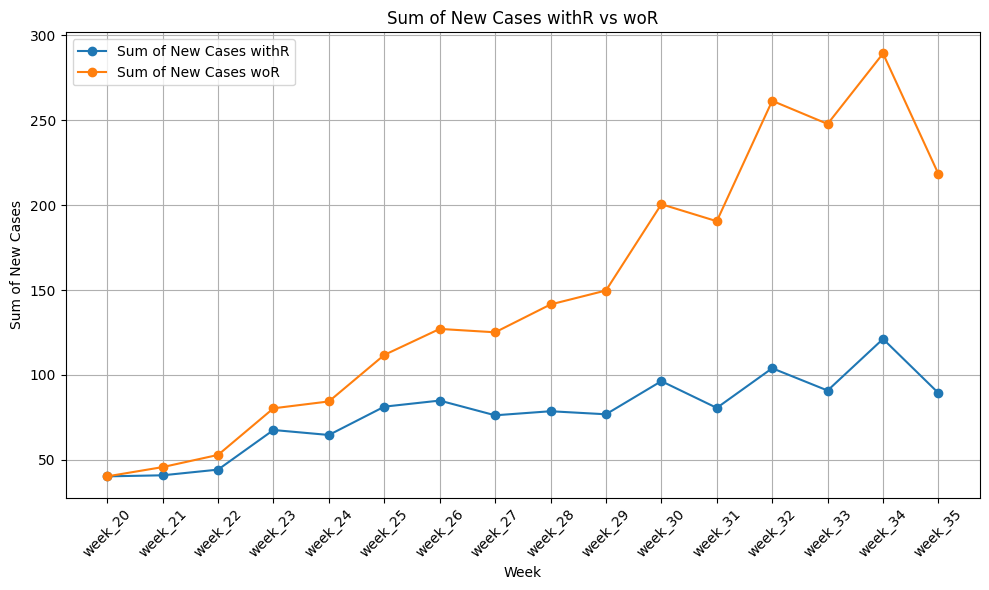

In [34]:
#@title graph
import matplotlib.pyplot as plt

# combining results_df
# Merge the two dataframes on the 'Week' column
merged_df = pd.merge(results_df_withR, results_df_woR, on='Week')
merged_df.to_excel('/content/drive/MyDrive/SP/simulation results/Simulation results_by_week_onlyS_241116.xlsx', index=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Week'], merged_df['Sum of New Cases withR'], marker='o', linestyle='-', label='Sum of New Cases withR')
plt.plot(merged_df['Week'], merged_df['Sum of New Cases woR'], marker='o', linestyle='-', label='Sum of New Cases woR')

plt.xlabel('Week')
plt.ylabel('Sum of New Cases')
plt.title('Sum of New Cases withR vs woR')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

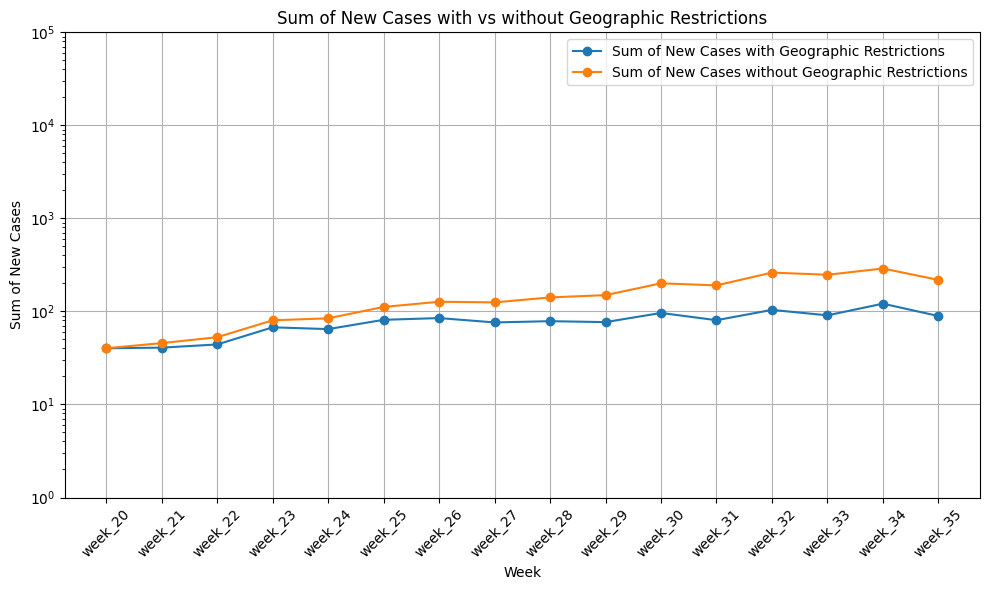

In [35]:
#@title Plotting with a logarithmic scale
plt.figure(figsize = (10,6))
plt.plot(merged_df['Week'], merged_df['Sum of New Cases withR'], marker = 'o', linestyle = '-', label = 'Sum of New Cases with Geographic Restrictions')
plt.plot(merged_df['Week'], merged_df['Sum of New Cases woR'], marker = 'o', linestyle = '-', label = 'Sum of New Cases without Geographic Restrictions')
plt.xlabel('Week')
plt.ylabel('Sum of New Cases')
plt.title('Sum of New Cases with vs without Geographic Restrictions')
plt.yscale('log') # Set y-axis to lagrithmic scale
plt.yticks([1, 10, 100, 1000, 10000, 100000])  # Set custom y-axis ticks
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
merged_df

,Week,Sum of New Cases withR,Sum of New Cases woR
0,week_20,40.195160,40.195160
1,week_21,40.814443,45.649691
2,week_22,44.166600,52.829794
3,week_23,67.509344,80.295083
4,week_24,64.574141,84.347962
5,week_25,81.261017,111.741779
6,week_26,84.847123,127.073635
7,week_27,76.170681,125.077288
8,week_28,78.565325,141.485757
9,week_29,76.774295,149.707193


In [37]:
merged_df.to_excel("/content/drive/MyDrive/SP/input tables_woR/result_summary_withinSeoul.xlsx")

In [38]:
real_case = pd.read_excel("/content/drive/MyDrive/SP/weekly new cases Seoul.xlsx")

In [39]:
real_case.rename(columns = {'Sum of New Cases withR': 'Real New Cases withR'}, inplace = True)
real_case.head()

,week,Real New Cases withR
0,week_20,30
1,week_21,87
2,week_22,113
3,week_23,127
4,week_24,98


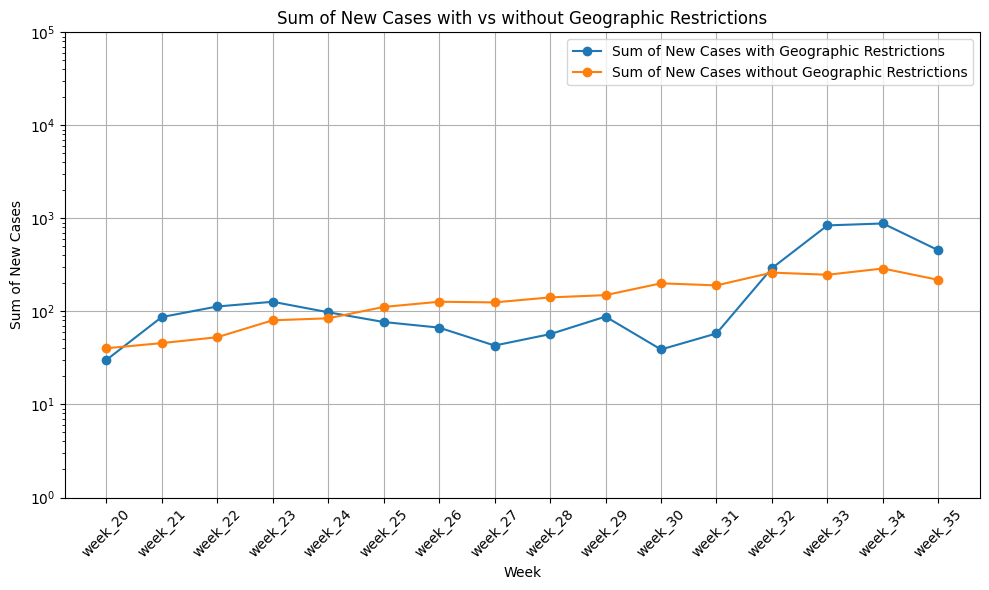

In [40]:
#@title Plotting Real Case Trend with a logarithmic scale
# Merge the two dataframes on the 'Week' column
merged_df = pd.merge(merged_df, real_case, left_on='Week', right_on = 'week')
plt.figure(figsize = (10,6))
plt.plot(merged_df['Week'], merged_df['Real New Cases withR'], marker = 'o', linestyle = '-', label = 'Sum of New Cases with Geographic Restrictions')
plt.plot(merged_df['Week'], merged_df['Sum of New Cases woR'], marker = 'o', linestyle = '-', label = 'Sum of New Cases without Geographic Restrictions')
plt.xlabel('Week')
plt.ylabel('Sum of New Cases')
plt.title('Sum of New Cases with vs without Geographic Restrictions')
plt.yscale('log') # Set y-axis to lagrithmic scale
plt.yticks([1, 10, 100, 1000, 10000, 100000])  # Set custom y-axis ticks
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
merged_df.drop(['week'], axis = 1)

,Week,Sum of New Cases withR,Sum of New Cases woR,Real New Cases withR
0,week_20,40.195160,40.195160,30
1,week_21,40.814443,45.649691,87
2,week_22,44.166600,52.829794,113
3,week_23,67.509344,80.295083,127
4,week_24,64.574141,84.347962,98
5,week_25,81.261017,111.741779,77
6,week_26,84.847123,127.073635,67
7,week_27,76.170681,125.077288,43
8,week_28,78.565325,141.485757,57
9,week_29,76.774295,149.707193,88


In [42]:
merged_df

,Week,Sum of New Cases withR,Sum of New Cases woR,week,Real New Cases withR
0,week_20,40.195160,40.195160,week_20,30
1,week_21,40.814443,45.649691,week_21,87
2,week_22,44.166600,52.829794,week_22,113
3,week_23,67.509344,80.295083,week_23,127
4,week_24,64.574141,84.347962,week_24,98
5,week_25,81.261017,111.741779,week_25,77
6,week_26,84.847123,127.073635,week_26,67
7,week_27,76.170681,125.077288,week_27,43
8,week_28,78.565325,141.485757,week_28,57
9,week_29,76.774295,149.707193,week_29,88


In [43]:
# Calculate the sum of each column
sum_withR = merged_df['Sum of New Cases withR'].sum()
sum_woR = merged_df['Sum of New Cases woR'].sum()

# Calculate the percentage difference
percentage_difference = ((sum_woR - sum_withR) / sum_withR) * 100

# Print the results
print(f"Sum of 'Sum of New Cases withR': {sum_withR}")
print(f"Sum of 'Sum of New Cases woR': {sum_woR}")
print(f"Percentage difference: {percentage_difference:.2f}%")

Sum of 'Sum of New Cases withR': 1236.8212678755276
Sum of 'Sum of New Cases woR': 2366.534178599858
Percentage difference: 91.34%
